<a href="https://colab.research.google.com/github/ngolla/video-captioning/blob/master/captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
from google.colab import drive
from pathlib import Path
import io
import pandas as pd
import spacy
import numpy as np
# import counter class from collections module 
from collections import Counter 
import matplotlib.pyplot as plt
# Import seaborn
import seaborn as sns
import string
import time

function to upload caption corpus and save it to drive and save data to pandas dataframe

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_csv(file_name, drive_path):
  corpus_file=drive_path.joinpath(file_name)
  if(corpus_file.is_file()):
    corpus_df=pd.read_csv(str(corpus_file))
  else:
    uploaded=files.upload()
    corpus_df=pd.read_csv(io.BytesIO(uploaded[file_name]))
    corpus_df.to_csv(corpus_file)
  return corpus_df

In [ ]:
drive_path=Path("/content/drive/My Drive")
annotations=load_csv('video_corpus.csv', drive_path)

Data exploration : Annotation dataframe

In [ ]:
annotations.head(2)

,Unnamed: 0,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description
0,0,mv89psg6zh4,33,46,588702,unverified,55,Slovene,Papagaj se umiva pod tekočo vodo v lijaku.
1,1,mv89psg6zh4,33,46,588702,unverified,37,Slovene,Papagaj se umiva pod tekočo vodo v lijaku.


In [ ]:
def extractBy(title, value, dataset):
  return dataset[dataset[title]==value]

In [ ]:
english_ants=extractBy('Language','English', annotations)

In [ ]:
print('Annotations shape: ',annotations.shape)
print('Columns ',annotations.columns)
print('Number of Languages available ',len(annotations['Language'].unique()))
print('Language available ',annotations['Language'].unique())
# only english annotations

print('English corpus available data ',english_ants.shape) # 85511 rows and 8 columns
print('Total number of columns ',english_ants.columns)

Annotations shape:  (122604, 9)
Columns  Index(['Unnamed: 0', 'VideoID', 'Start', 'End', 'WorkerID', 'Source',
       'AnnotationTime', 'Language', 'Description'],
      dtype='object')
Number of Languages available  35
Language available  ['Slovene' 'Macedonian' 'German' 'Romanian' 'Georgian' 'Serbian' 'French'
 'Gujarati' 'Hindi' 'English' 'Tamil' 'Dutch' 'Tagalog' 'Polish' 'Spanish'
 'Russian' 'Arabic' 'Italian' 'Filipino' 'Malayalam' 'Chinese'
 'Portuguese' 'Estonian' 'Norwegian' 'Malay' 'Urdu' 'Hungarian' 'Turkish'
 'Indonesian' 'Danish' 'Bosnian' 'Albanian' 'Bulgarian' 'Marathi'
 'Swedish']
English corpus available data  (85511, 9)
Total number of columns  Index(['Unnamed: 0', 'VideoID', 'Start', 'End', 'WorkerID', 'Source',
       'AnnotationTime', 'Language', 'Description'],
      dtype='object')


In [ ]:
print(english_ants.describe()) #describe 
print(english_ants.info) # info
print(english_ants.dtypes) # type

          Unnamed: 0         Start           End       WorkerID  AnnotationTime
count   85511.000000  85511.000000  85511.000000   85511.000000    85511.000000
mean    61422.715148     74.137351     84.358480  522296.482850       90.375846
std     35409.262471    115.452416    114.966295  260078.333787      200.714320
min        18.000000      0.000000      3.000000  100234.000000        5.000000
25%     30816.500000      7.000000     18.000000  297776.000000       24.000000
50%     61443.000000     30.000000     41.000000  550906.000000       41.000000
75%     92065.500000     93.000000    101.000000  760882.000000       80.000000
max    122601.000000    997.000000   1004.000000  998645.000000     3590.000000
<bound method DataFrame.info of         Unnamed: 0  ...                                        Description
18              18  ...  A bird in a sink keeps getting under the runni...
19              19  ...                       A bird is bathing in a sink.
20              20  ...

#Data cleaning

In [ ]:
english_ants=english_ants.drop(columns='Unnamed: 0')

In [ ]:
cols = ['VideoID', 'Start', 'End']
print(english_ants.groupby(by=cols)['Description'].count()) #Total number of corpus text for each video chunk
print(english_ants.groupby(by='VideoID')['Description'].count() )

VideoID      Start  End
-4wsuPCjDBc  5      15     29
-7KMZQEsJW4  205    208    42
-8rBYNP0UKM  50     82     52
             194    201    56
-8y1Q0rA3n8  95     102    27
                           ..
zulPFoY64wE  26     33     34
zv2RIbUsnSw  159    162    25
             335    341    28
zxB4dFJhHR8  1      9      53
zzit5b_-ukg  5      20     41
Name: Description, Length: 2088, dtype: int64
VideoID
-4wsuPCjDBc     29
-7KMZQEsJW4     42
-8rBYNP0UKM    108
-8y1Q0rA3n8     59
-9CUm-2cui8     28
              ... 
zuYZ5kPatJE     45
zulPFoY64wE     34
zv2RIbUsnSw     53
zxB4dFJhHR8     53
zzit5b_-ukg     41
Name: Description, Length: 1586, dtype: int64


Data exploration:

Number of video chunks for each video

In [ ]:
def merge_rows(cols,df):
  df=df.assign(AnnotationID=df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1))
  return df

In [ ]:
english_ants=merge_rows(cols,english_ants)
corpusVideoIds=english_ants['AnnotationID'].unique()
len(corpusVideoIds)

2088

#Statistical inference:

Consider a video, this video has 

In [ ]:
specificVideo=english_ants.query('VideoID=="-_hbPLsZvvo"').filter(items=cols)
print('Number of chunks in a video ',len(specificVideo.drop_duplicates())) #-_hbPLsZvvo has 11 chunks
print('Number of corpus in each chunk of video')
print(english_ants.set_index('AnnotationID').filter(regex='-_hbPLsZvvo*',axis=0).groupby(by='AnnotationID')['Description'].count())
print('Description of each chunk video corpus')
print(english_ants.set_index('AnnotationID').filter(like='-_hbPLsZvvo_323_328',axis=0)['Description'])

Number of chunks in a video  11
Number of corpus in each chunk of video
AnnotationID
-_hbPLsZvvo_172_179    44
-_hbPLsZvvo_18_25      35
-_hbPLsZvvo_19_25      48
-_hbPLsZvvo_19_26      42
-_hbPLsZvvo_211_219    38
-_hbPLsZvvo_269_275    44
-_hbPLsZvvo_288_305    42
-_hbPLsZvvo_323_328    38
-_hbPLsZvvo_43_55      59
-_hbPLsZvvo_49_55      38
-_hbPLsZvvo_5_8        49
Name: Description, dtype: int64
Description of each chunk video corpus
AnnotationID
-_hbPLsZvvo_323_328                            A man is arranging sushi.
-_hbPLsZvvo_323_328                A person is arranging food on a dish.
-_hbPLsZvvo_323_328    A person is making a hot dog piece look like a...
-_hbPLsZvvo_323_328                        A woman arranges a food dish.
-_hbPLsZvvo_323_328                                A woman cuts a squid.
-_hbPLsZvvo_323_328    A woman is adding eyes to squash cut into ghos...
-_hbPLsZvvo_323_328    A woman is arranging some food and decorating it.
-_hbPLsZvvo_323_328               

Remove columns that are not useful

As we already have annotation ID as we dont need ['VideoID', 'Start', 'End']

Similarly, we know that all the description here are in english, let's remove 'Language' as well


In [ ]:
english_ants.columns

Index(['VideoID', 'Start', 'End', 'WorkerID', 'Source', 'AnnotationTime',
       'Language', 'Description', 'AnnotationID'],
      dtype='object')

In [ ]:
def removeColums(dataset, columns):
  return dataset.drop(columns=columns)

In [ ]:
columns=['VideoID', 'Start', 'End', 'WorkerID', 'Source','Language','AnnotationTime']
final_corpus=removeColums(english_ants, columns)

In [ ]:
final_corpus.head()

,Description,AnnotationID
18,A bird in a sink keeps getting under the runni...,mv89psg6zh4_33_46
19,A bird is bathing in a sink.,mv89psg6zh4_33_46
20,A bird is splashing around under a running fau...,mv89psg6zh4_33_46
21,A bird is bathing in a sink.,mv89psg6zh4_33_46
22,A bird is standing in a sink drinking water th...,mv89psg6zh4_33_46


There is one missing value, hence removing that row will be good decision, because without description there is no meaning to the row

In [ ]:
final_corpus[final_corpus['Description'].isna()]

,Description,AnnotationID
71570,NaN,SKhmFSV-XB0_12_18


In [ ]:
def drop_nullvalues(df):
  df=df.dropna()
  return df

In [ ]:
#Drop null values
final_corpus=drop_nullvalues(final_corpus)

In [ ]:
 def addPath(text_data,video_path):
   text_data['VideoPath'] = text_data.apply(lambda row: row['AnnotationID']+'.npy', axis=1)
   text_data['VideoPath'] = text_data['VideoPath'].map(lambda x: video_path.joinpath(x))
   text_data = text_data[text_data['VideoPath'].map(lambda x: x.is_file())]
   text_data = text_data[text_data['Description'].map(lambda x: isinstance(x, str))]
   unique_filenames = sorted(text_data['VideoPath'].unique())
   data = text_data[text_data['VideoPath'].map(lambda x: x in unique_filenames)]
   return data

In [ ]:
video_path=drive_path.joinpath('VideoArrays')
len(list(video_path.glob('*')))
final_corpus=addPath(final_corpus, video_path)

In [ ]:
print(len(list(np.unique(final_corpus['VideoPath']))))
print(len(list(np.unique(final_corpus['AnnotationID']))))

1969
1969


A counter tool is provided to support convenient and rapid tallies. For example:

>>> # Tally occurrences of words in a list
>>> cnt = Counter()
>>> for word in ['red', 'blue', 'red', 'green', 'blue', 'blue']:
...     cnt[word] += 1
>>> cnt
Counter({'blue': 3, 'red': 2, 'green': 1})

>>> # Find the ten most common words in Hamlet
>>> import re
>>> words = re.findall(r'\w+', open('hamlet.txt').read().lower())
>>> Counter(words).most_common(10)
[('the', 1143), ('and', 966), ('to', 762), ('of', 669), ('i', 631),
 ('you', 554),  ('a', 546), ('my', 514), ('hamlet', 471), ('in', 451)]

https://docs.python.org/2/library/collections.html

In [ ]:
def utility_counter(data):
  unique_files=np.unique(data.AnnotationID.values)
  print('The number of unique files :', str(len(unique_files)))
  counter_dict=Counter(data.AnnotationID.values)
  print(counter_dict.keys())
  print(counter_dict)
  print('The distribution of the number of captions for each video clip ')
  ct=Counter(Counter(data.AnnotationID.values).values())
  print(ct)
  return counter_dict
  

In [ ]:
w=utility_counter(final_corpus)

The number of unique files : 1969
dict_keys(['mv89psg6zh4_33_46', 'ZbzDGXEwtGc_6_15', 'g36ho6UrBz0_5_20', '04Gt01vatkk_248_265', 'buJ5HDCinrM_150_166', 'M_TP6UTrh30_343_358', '8mSUD7JGNO0_174_181', 'ljGcQocjSs4_38_60', 'n2NLoLNecgI_168_178', '6q1dX6thX3E_286_295', 'mFCf8lLXrUc_25_35', '6eokrw6_bjU_1_9', 'E2r6nnkwl0c_6_18', 'n016q1w8Q30_2_11', 'rQuNYxNmA6M_0_4', 'ByGspTdA1ug_16_24', '-_hbPLsZvvo_323_328', '6t0BpjwYKco_217_229', 'MTkGPfMRXtc_5_21', 'aeA-HN7BMdo_34_41', 'WWf0Z6ak3Dg_5_15', 'DBvSfds3FH4_76_80', 'Ms3QdGIzltU_1_16', 'nS6oQxX_Qi8_2_12', 'pDvzOLRLjPc_0_8', 'LQ-jv8g1YVI_1_6', 'kquB3rIgfGk_640_645', 'BVjvRpmHg0w_157_165', 'QzcTlEpAigQ_0_14', 'AysIdzGF-7M_6_14', 'iwpnUHFhjWc_9_14', 'bJJndejsUWc_88_98', 'Xh6rdpJNaf0_0_15', 'nwk4m329bLw_2_10', 'ItFqogTmAvQ_389_395', 'PCXHuseKwDc_17_20', '9Bxknsvy3jQ_53_58', 'a1Y73sPHKxw_0_5', 'C1MNCR1o9lU_0_7', 'zzit5b_-ukg_5_20', 'w9mqbwOIkVg_6_12', 'lAznAeFFldg_6_10', 'VF1K_6ZSOAY_23_28', 'j2Dhf-xFUxU_13_20', '_txL575S_OA_13_23', 'E6sqA9QtV5I_195

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

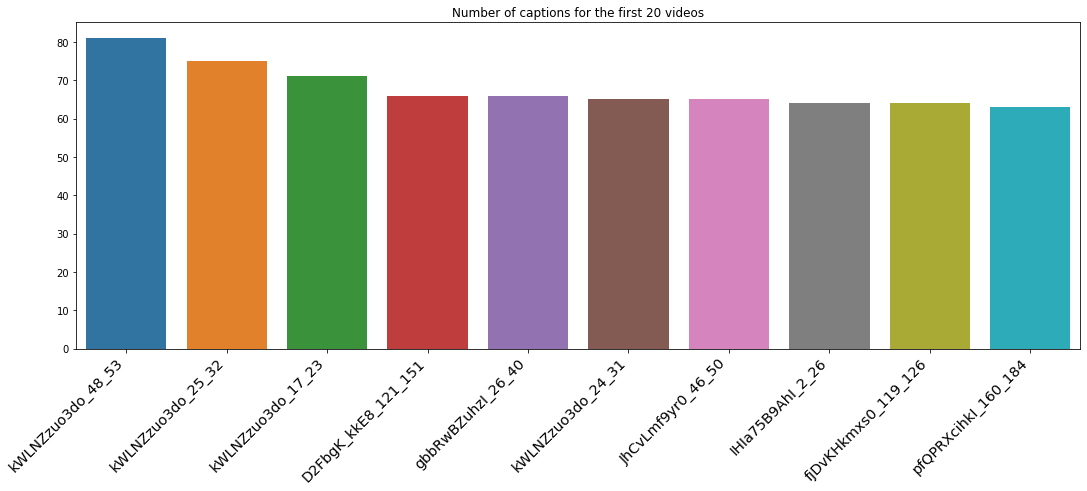

In [ ]:

common_file = [word[0] for word in w.most_common(10)]
common_counts = [word[1] for word in w.most_common(10)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=common_file, y=common_counts)
plt.title('Number of captions for the first 20 videos')
#plt.show()
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large' )

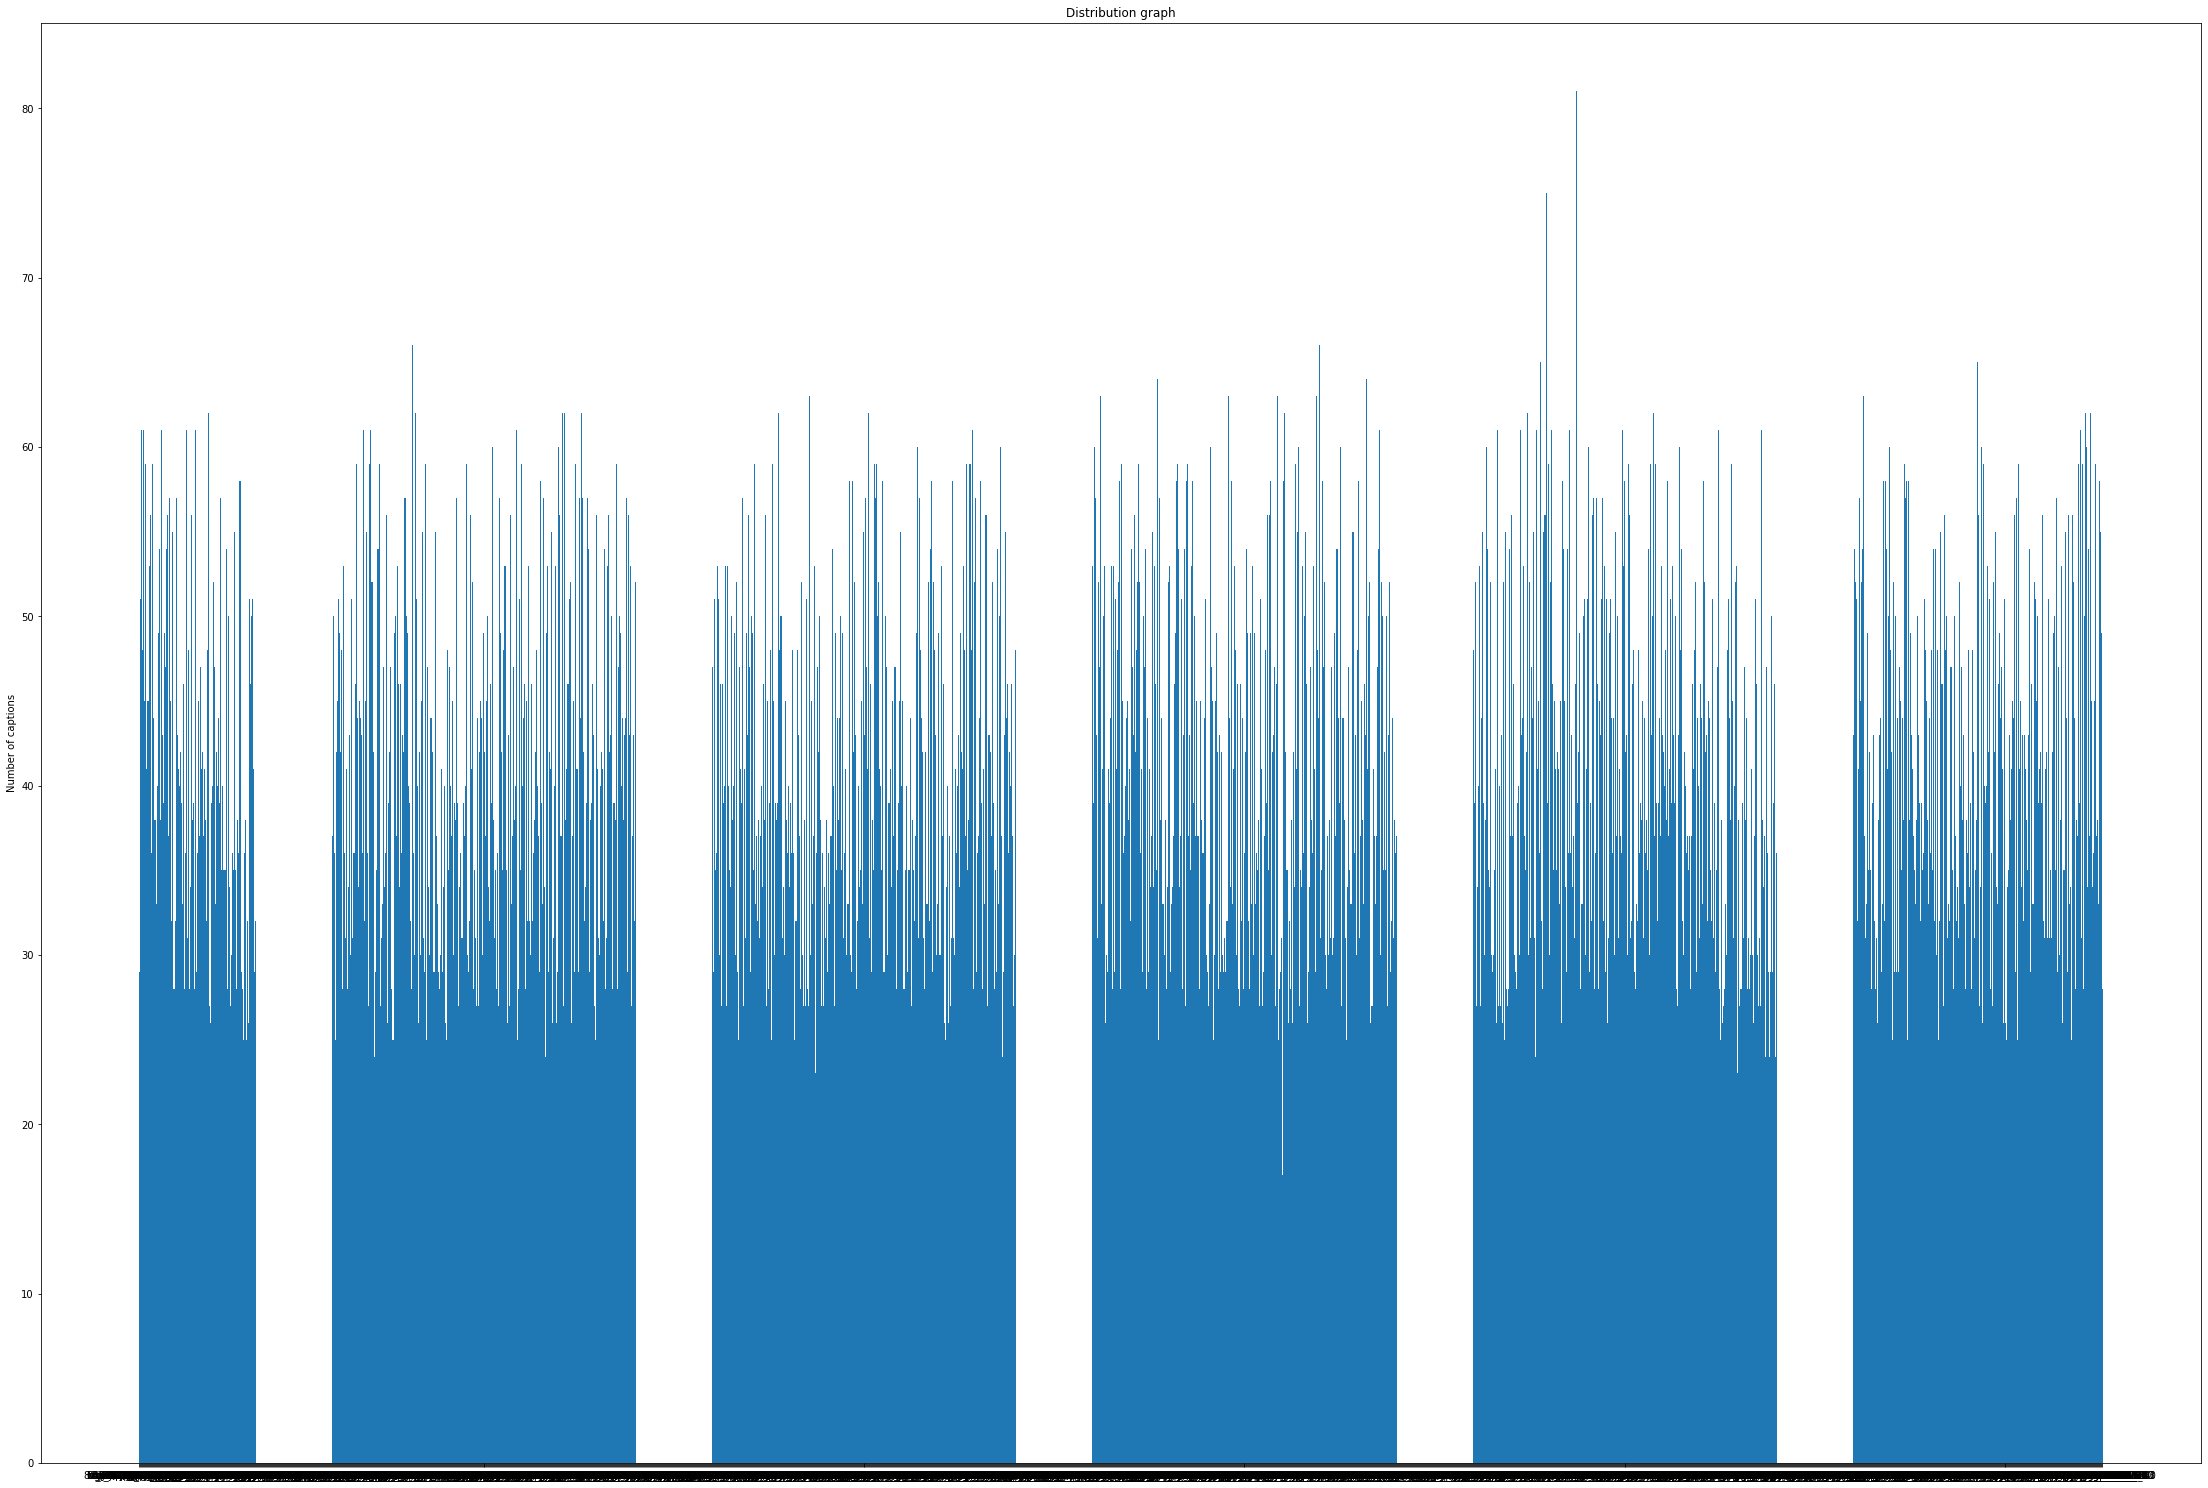

In [ ]:
#plt.figure(figsize=(12,12))
fig = plt.figure()
ax = fig.add_axes([0,0,5,5])
ax.bar(w.keys(), w.values())
ax.set_ylabel('Number of captions')
ax.set_title('Distribution graph')
plt.show()
#plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large' )

In [ ]:
def convert_to_lower(data, title):
  return [x.lower() for x in data[title]]

In [ ]:
final_corpus['Description'] = convert_to_lower(final_corpus, 'Description')

#View word count

In [ ]:
def visualize_words(all_words, plt_title='Top appearing words'):
  common_words = [word[0] for word in all_words]
  common_counts = [word[1] for word in all_words]
  plt.figure(figsize=(18,6))
  sns.barplot(x=common_words, y=common_counts)
  plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large' )

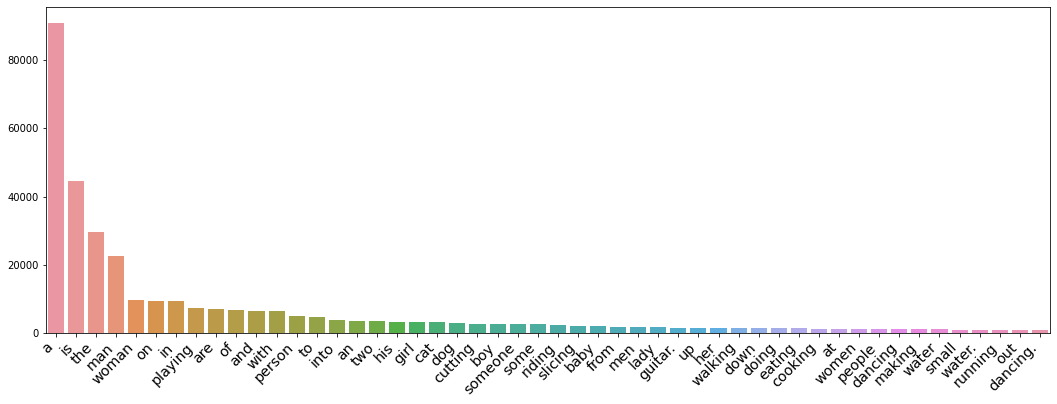

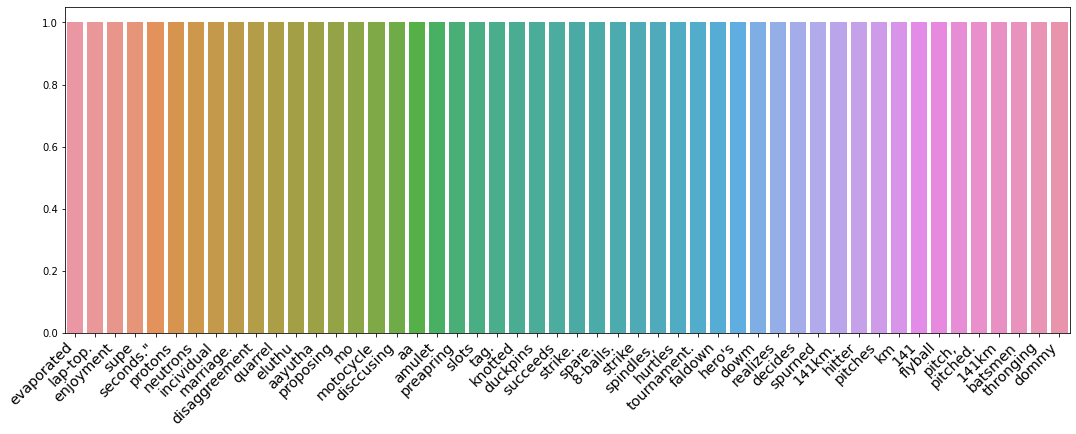

In [ ]:
def visualize_description(dataset, title, plt_title='Top appearing words'):
  all_words=Counter(" ".join(dataset[title]).split())
  best_50=all_words.most_common(50)
  least=all_words.most_common()[:-50-1:-1]
  visualize_words(best_50, " 50 best "+ plt_title)
  visualize_words(least, " 50 least  "+ plt_title)

visualize_description(final_corpus,'Description', 'Common words')



In [ ]:
final_corpus=final_corpus.reindex(['AnnotationID','VideoPath','Description'], axis="columns").reset_index()

In [ ]:
final_corpus.drop(labels='index',inplace=True, axis= 'columns')

In [ ]:
# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)


# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

In [ ]:
for i, caption in enumerate(final_corpus.Description.values):
    newcaption = text_clean(caption)
    final_corpus['Description'].iloc[i] = newcaption

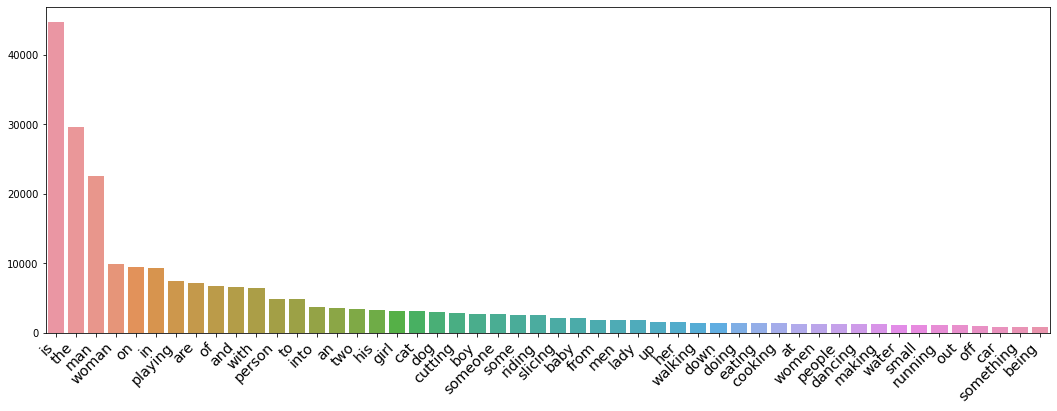

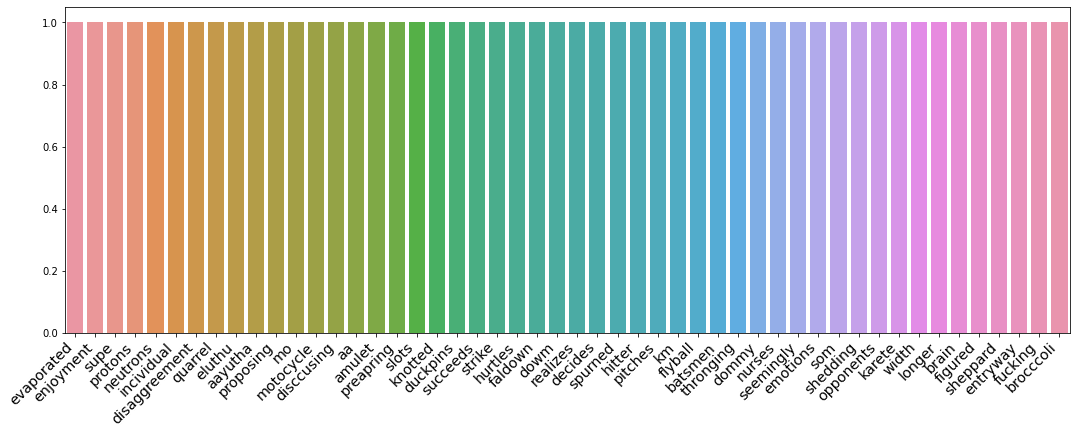

In [ ]:
visualize_description(final_corpus,'Description', 'Common words After Noise reduction')

In [ ]:
final_corpus.head()

,AnnotationID,VideoPath,Description
0,mv89psg6zh4_33_46,/content/drive/My Drive/VideoArrays/mv89psg6zh...,bird in sink keeps getting under the running ...
1,mv89psg6zh4_33_46,/content/drive/My Drive/VideoArrays/mv89psg6zh...,bird is bathing in
2,mv89psg6zh4_33_46,/content/drive/My Drive/VideoArrays/mv89psg6zh...,bird is splashing around under running
3,mv89psg6zh4_33_46,/content/drive/My Drive/VideoArrays/mv89psg6zh...,bird is bathing in
4,mv89psg6zh4_33_46,/content/drive/My Drive/VideoArrays/mv89psg6zh...,bird is standing in sink drinking water that ...


In [ ]:
def preprocess_captions(data):
  total_captions=[]
  for caption in data['Description'].astype(str):
    caption='<start> '+caption+' <end>'
    total_captions.append(caption)
  return total_captions
total_captions=preprocess_captions(final_corpus)

In [ ]:
final_corpus['captions']=total_captions

In [ ]:
final_corpus.head()

,AnnotationID,VideoPath,Description,captions
0,mv89psg6zh4_33_46,/content/drive/My Drive/VideoArrays/mv89psg6zh...,bird in sink keeps getting under the running ...,<start> bird in sink keeps getting under the ...
1,mv89psg6zh4_33_46,/content/drive/My Drive/VideoArrays/mv89psg6zh...,bird is bathing in,<start> bird is bathing in <end>
2,mv89psg6zh4_33_46,/content/drive/My Drive/VideoArrays/mv89psg6zh...,bird is splashing around under running,<start> bird is splashing around under runnin...
3,mv89psg6zh4_33_46,/content/drive/My Drive/VideoArrays/mv89psg6zh...,bird is bathing in,<start> bird is bathing in <end>
4,mv89psg6zh4_33_46,/content/drive/My Drive/VideoArrays/mv89psg6zh...,bird is standing in sink drinking water that ...,<start> bird is standing in sink drinking wat...


In [ ]:
from keras.preprocessing.text import Tokenizer
# prepare tokenizer
tokenizer = Tokenizer(
    num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
    split=' ', char_level=False, oov_token=None, document_count=0
)
tokenizer.fit_on_texts(total_captions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 11158


In [ ]:
# integer encode descriptions
sequences = tokenizer.texts_to_sequences(total_captions)

The model will require all output sequences to have the same length for training. We can achieve this by padding all encoded sequences to have the same length as the longest encoded sequence. We can pad the sequences with 0 values after the list of words. Keras provides the pad_sequences() function to pad the sequences.

In [ ]:
from keras.preprocessing.sequence import pad_sequences
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = pad_sequences(sequences, padding='post')
cap_vector[0].shape

(89,)

In [ ]:
max_len=len(cap_vector[0])
max_len

89

In [ ]:
print('Number of captions: ', str(len(total_captions)))
print('length of sequences : ',str(len(sequences)))
print('first sequence: ', sequences[0])
print('first sequence length : ', len(sequences[0]))
print('first caption: ', total_captions[0])
print('padding vector ', cap_vector.shape)
print('first caption padding vector ', cap_vector[0].shape)
print('Max len of single padding vector or number of rows ', max_len)

Number of captions:  80799
length of sequences :  80799
first sequence:  [2, 191, 8, 777, 1833, 180, 242, 4, 47, 45, 30, 1]
first sequence length :  12
first caption:  <start>  bird in sink keeps getting under the running water from <end>
padding vector  (80799, 89)
first caption padding vector  (89,)
Max len of single padding vector or number of rows  89


In [ ]:
video_paths=np.unique(final_corpus.VideoPath)

In [ ]:
def load_videos_as_numpy(video_paths):
  video_np={}
  for eachVideo in tqdm(np.unique(video_paths)):
    video_np[eachVideo.stem]=np.load(eachVideo)
  return video_np


In [ ]:
video_np=load_videos_as_numpy(video_paths)
print(len(video_np))

1969


In [ ]:
keepindex = []
videos_dt=[]
for i, fnm in enumerate(final_corpus.AnnotationID):
    if fnm in video_np.keys():
      videos_dt.append(video_np[fnm])
      keepindex.append(i)
    break;

#fnames = final_corpus["AnnotationID"].iloc[keepindex].values

IndexError: ignored

In [ ]:
# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
# Create training and validation sets using an 80-20 split
fnames = final_corpus["AnnotationID"].values
vid_name_train, vid_name_val, cap_train, cap_val = train_test_split(videos_dt,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)
len(vid_name_train), len(cap_train), len(vid_name_val), len(cap_val)
# Feel free to change these parameters according to your system's configuration

(64639, 64639, 16160, 16160)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(vid_name_train) // BATCH_SIZE
# Shape of the vector extracted from Vgg16 is (64, 2048)
# These two variables represent that vector shape
features_shape = 4096
attention_features_shape = 80
#videos_dt[0].shape #(80, 4096)

In [ ]:
import pickle
outfile = open(drive_path.joinpath('pickle.dat'),'wb')
pickle.dump((vid_name_train, cap_train),outfile)
outfile.close()

In [ ]:
import pickle
(vid_name_train, cap_train)=pickle.load(open( drive_path.joinpath('pickle.dat'), "rb" ))



In [ ]:
np.asarray(vid_name_train,dtype=np.float32)

In [ ]:
list(drive_path.glob('*'))

[PosixPath('/content/drive/My Drive/Colab Notebooks'),
 PosixPath('/content/drive/My Drive/YouTubeClips.tar'),
 PosixPath('/content/drive/My Drive/video_corpus.csv'),
 PosixPath('/content/drive/My Drive/.ipynb_checkpoints'),
 PosixPath('/content/drive/My Drive/VideoArrays'),
 PosixPath('/content/drive/My Drive/pickle.dat')]

In [ ]:
vid_name_train[0].shape

(80, 4096)

In [ ]:
import numpy as np


In [ ]:
np.asarray(vid_name_train, dtype=np.float32)

NameError: ignored

In [ ]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((vid_name_train, cap_train))
#train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))

In [ ]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
# Load the numpy files
#def map_func(vid_name, cap):
#  img_tensor=
#  return img_tensor, cap

In [ ]:
# Use map to load the numpy files in parallel
#dataset = dataset.map(lambda item1, item2: tf.numpy_function(
#          map_func, [item1, item2], [tf.float32, tf.int32]),
#          num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

Checkpoints

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:

EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
      print(img_tensor)
      batch_loss, t_loss = train_step(img_tensor, target)
      total_loss += t_loss
      if batch % 100 == 0:
        print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

UnknownError: ignored

In [ ]:
video_np['ao-9B8IV9_E_37_44'].shape

(80, 4096)

In [ ]:
final_corpus['sequences']=sequences

In [ ]:
final_corpus.columns

Index(['AnnotationID', 'VideoPath', 'Description', 'captions'], dtype='object')

In [ ]:
train=final_corpus[final_corpus.AnnotationID=='_0nX-El-ySo_83_93']

#video_np['_0nX-El-ySo_83_93'].shape
#Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train, fn_train)

In [ ]:
videos_dt, keepindex = [],[]
for i, fnm in enumerate(final_corpus.AnnotationID):
    if fnm in video_np.keys():
        videos_dt.append(video_np[fnm])
        keepindex.append(i)

fnames = final_corpus["AnnotationID"].iloc[keepindex].values
captions_dt = final_corpus["sequences"].iloc[keepindex].values
#videos_dt = np.array(videos_dt)

In [ ]:
prop_test, prop_val = 0.2, 0.2 

N = len(captions_dt)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(captions_dt,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(videos_dt,Ntest,Nval)
fn_test,  fn_val, fn_train   = split_test_val_train(fnames,Ntest,Nval)

In [ ]:
maxlen = np.max([len(text) for text in captions_dt])

In [ ]:
print(maxlen)
print(len(dt_test),  len(dt_val), len(dt_train))
print(len(di_test),  len(di_val), len(di_train))
print(len(fn_test),  len(fn_val), len(fn_train))

89
16159 16159 48481
16159 16159 48481
16159 16159 48481


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dvideos, dfnames):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dvideos))
    Xtext, Xvideo, ytext = [],[],[]
    for text,image,fname in zip(dtexts,dvideos, dfnames):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Xvideo.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Xvideo = np.array(Xvideo)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Xvideo.shape,ytext.shape))
    return(Xtext,Xvideo,ytext)


#Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train, fn_train)
#Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val, fn_train)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

In [ ]:
Xtext_train, Ximage_train, ytext_train = preprocessing(captions_dt,videos_dt, fnames)

# captions/images = 32
 (213, 89) (213, 80, 4096) (213, 11158)


In [ ]:
from keras import layers
from keras import models
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

11158
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 89)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 89, 64)       714112      input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 256)          328704      embedding_1[0][0]                
_________________________________________________________________________________

In [ ]:
# fit model
import time
start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=64)
#,
                  #validation_data=([Ximage_val, Xtext_val], ytext_val))
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/5


ValueError: ignored

In [ ]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
# pad all sequences to a fixed length
max_length = max(len(s) for s in sequences)
print('Description Length: %d' % max_length)
padded = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
print('Shape of padded text matrix ',padded.shape) # there are 80799 captions and each caption should have 89 words
print('Single captions after padding', padded[0]) # we can see that first 12 are filled with sequence values, rest of them are replaced with 0

In [ ]:
total_captions[:10]

**en_core_web_sm**

English multi-task CNN trained on OntoNotes. Assigns context-specific token vectors, POS tags, dependency parse and named entities

SIZE : 11 MB

PIPELINE  : tagger, parser, ner

In [ ]:
nlp=spacy.load('en_core_web_sm')

Data Cleaning:

Noise Reduction Methods
1. Using split method with space
2. Using re library of python, but doent support unicode characters
3. Using regex library of python
4. Using spacy, this will split data in terms of tokens. These tokens have is_* methods like is_space, is_punctuation, is_stop etc
Noise here means:

Remove punctuation
Remove single words
Remove numerical values
Lemmetization and Stemming

Word wrapping

In [ ]:
def tokenize_spacy(text):
  return mytokens

In [ ]:
final_corpus.head()

In [ ]:
td.head()

In [ ]:
td['test']= [ tokenize_spacy(each) for each in td['Description']]